# Herron Topic 3 - Quantitative Value Investing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Introduction

This notebook adapts the portfolio formation approach from @fama1993common, who show that firms with high book-to-market equity ratios (value stocks) tend to outperform those with low ratios (growth stocks), forming the basis of the value factor in their three-factor model.
This notebook relies on two large data files.
You can find these files in our [shared OneDrive folder](https://northeastern-my.sharepoint.com/:f:/g/personal/r_herron_northeastern_edu/ElSKCp7KsodKq21d2ydTIL8BIaha56J0VxUm7CxObo-wVA?e=1s8bB8) or our [Notebook and Syllabus folder on Canvas](https://northeastern.instructure.com/courses/207607/files/folder/Notebooks%20and%20Syllabus).
These two files are:

1. Firm-level market data (e.g., stock prices and share counts) from the [Center for Research in Security Prices (CRSP)](https://www.crsp.org/) in `crsp.csv` 
1. Firm-level fundamentals (i.e., financial statement information) from [Compustat](https://www.marketplace.spglobal.com/en/datasets/compustat-fundamentals-(8)) in `compustat.csv`

This notebook walks you through the steps to test a quantitative value investing strategy based on the book-to-market equity ratio (B/M).
I based this lecture notebook on @gray2012quantitative [Chapters 1 and 7], which presents much more on quantitative value investing.

## Import the data from CRSP and Compustat

### CRSP

The CRSP data provide the following variables:

1. `PERMNO` is the stock identifier
1. `date` is the last trading day of the month
1. `SHRCD` indicates share class, and we can ignore it
1. `PRC` is the share price in dollars, and negative prices indicate the price is the midpoint of the bid-ask spread instead of a transaction
1. `SHROUT` is the number of shares outstanding in thousands

Read the CRSP data into a data frame named `crsp`.
Be sure to parse dates.
The codea `A`, `B`, and `C` indicate missing values.

In [3]:
crsp = (
    pd.read_csv(
        filepath_or_buffer='crsp.csv',
        parse_dates=['date'],
        na_values=list('ABC')
    )
    .query('date >= 1965')
    .sort_values(by=['PERMNO', 'date'])
    .assign(
        ME=lambda x: x['PRC'].abs() * x['SHROUT'] / 1000,
        date=lambda x: x['date'] + pd.offsets.MonthEnd(0)
    )
)

In [4]:
crsp.head()

,PERMNO,date,SHRCD,PRC,RET,SHROUT,ME
0,10000,1986-01-31,10,-4.3750,NaN,3680.0000,16.1000
1,10000,1986-02-28,10,-3.2500,-0.2571,3680.0000,11.9600
2,10000,1986-03-31,10,-4.4375,0.3654,3680.0000,16.3300
3,10000,1986-04-30,10,-4.0000,-0.0986,3793.0000,15.1720
4,10000,1986-05-31,10,-3.1094,-0.2227,3793.0000,11.7939


### Compustat

The Compustat data provide the following variables:

1. `GVKEY` is the S&P firm identifier
1. `LPERMNO` is the link between CRSP and Compustat
1. `datadate` is the date of the filing, which is the last day of the fiscal year
1. `fyear` is the fiscal year
1. `ceq` is the book value of equity
1. `ib` is income before extraordinary items
2. We can ignore the other variables that Wharton Research Data Services (WRDS) adds to this data set

Read the Compustat data into a data frame named `compustat`.
Be sure to parse dates.

In [5]:
compustat = (
    pd.read_csv(
        filepath_or_buffer='compustat.csv',
        parse_dates=['datadate']
    )
    .query('datadate >= 1965')
    .sort_values(['LPERMNO', 'fyear', 'datadate'])
    .drop_duplicates(subset=['LPERMNO', 'fyear'], keep='last')
)

In [6]:
compustat.head()

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,ib,costat
165681,13007,10000,1986-10-31,1986.0000,INDL,C,D,STD,USD,0.4180,-0.7300,I
165586,12994,10001,1986-06-30,1986.0000,INDL,C,D,STD,USD,5.4320,0.6690,I
165587,12994,10001,1987-06-30,1987.0000,INDL,C,D,STD,USD,5.3690,0.3120,I
165588,12994,10001,1988-06-30,1988.0000,INDL,C,D,STD,USD,5.5120,0.5420,I
165589,12994,10001,1989-06-30,1989.0000,INDL,C,D,STD,USD,6.3210,1.2080,I


## Create interim data frames

To test the book/market investing strategy, we need to match the following data:

1. Book value of equity for year $t-1$
2. Market value of equity from December of year $t-1$
3. Portfolios for year $t$ based on book and market values of equity in year $t-1$
4. Returns from July of year $t$ through June of year $t+1$

We will form portfolios once a year because the book value of equity updates once a year.
@fama1993common wait until June of year $t$ to form portfolios, ensuring financial data from year $t-1$ is public, then track returns from July in year $t$ through June in year $t+1$.
The simplest and clearest way to match these data is to create one data frame for each of these three data sets.

### Market value of equity from December of year $t-1$

Then create a new data frame `mve` that contains the latest market value of equity as of December.

In [14]:
mve = (
    crsp
    .query('ME > 0')
    .groupby(['PERMNO', pd.Grouper(key='date', freq='YE-DEC')])
    [['ME']]
    .last()
)

In [17]:
crsp.query('PERMNO == 10001').head(12)

,PERMNO,date,SHRCD,PRC,RET,SHROUT,ME
18,10001,1986-01-31,11,-6.1250,NaN,985.0000,6.0331
19,10001,1986-02-28,11,-6.2500,0.0204,985.0000,6.1562
20,10001,1986-03-31,11,-6.3125,0.0252,985.0000,6.2178
21,10001,1986-04-30,11,-6.3750,0.0099,985.0000,6.2794
22,10001,1986-05-31,11,-6.3125,-0.0098,985.0000,6.2178
23,10001,1986-06-30,11,-6.1250,-0.0131,985.0000,6.0331
24,10001,1986-07-31,11,-6.0625,-0.0102,985.0000,5.9716
25,10001,1986-08-31,11,-6.5000,0.0722,985.0000,6.4025
26,10001,1986-09-30,11,6.3750,-0.0031,991.0000,6.3176
27,10001,1986-10-31,11,6.6250,0.0392,991.0000,6.5654


In [18]:
mve.head()

ME
PERMNO date             
10000  1986-12-31 1.9816
       1987-12-31 0.8516
10001  1986-12-31 6.9370
       1987-12-31 5.8280
       1988-12-31 6.3623

### Book value of equity for year $t-1$

Create a new data frame `bve` that contains the latest book value of equity as of December.
Because some firms have fiscal years that do not end in December, use `.groupby()`, `pd.Grouper()` with `YE-DEC`, and `.last()` to roll forward earlier fiscal year ends.

In [7]:
bve = (
    compustat
    .query('ceq > 0')
    .groupby(by=['LPERMNO', pd.Grouper(key='datadate', freq='YE-DEC')])
    [['ceq']]
    .last()
)

In [13]:
compustat.query('LPERMNO == 10001').head()

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,ib,costat
165586,12994,10001,1986-06-30,1986.0000,INDL,C,D,STD,USD,5.4320,0.6690,I
165587,12994,10001,1987-06-30,1987.0000,INDL,C,D,STD,USD,5.3690,0.3120,I
165588,12994,10001,1988-06-30,1988.0000,INDL,C,D,STD,USD,5.5120,0.5420,I
165589,12994,10001,1989-06-30,1989.0000,INDL,C,D,STD,USD,6.3210,1.2080,I
165590,12994,10001,1990-06-30,1990.0000,INDL,C,D,STD,USD,7.1790,1.1310,I


In [8]:
bve.head()

ceq
LPERMNO datadate         
10000   1986-12-31 0.4180
10001   1986-12-31 5.4320
        1987-12-31 5.3690
        1988-12-31 5.5120
        1989-12-31 6.3210

### Portfolios for year $t$

In [24]:
1 + pd.qcut(x=np.arange(10), q=5, labels=False)

array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])

In [25]:
portfolios = (
    bve
    [['ceq']]
    .dropna()
    .rename_axis(index=['PERMNO', 'Date'])
    .join(
        other=(
            mve
            [['ME']]
            .dropna()
            .rename_axis(index=['PERMNO', 'Date'])
        ),
        how='inner'
    )
    .assign(BM=lambda x: x['ceq'] / x['ME'])
    .reset_index()
    .assign(
        Portfolio=lambda x: x.groupby('Date')['BM'].transform(lambda x: 1 + pd.qcut(x=x, q=10, labels=False)),
        Date=lambda x: x['Date'] + pd.DateOffset(months=7)
    )
    [['PERMNO', 'Date', 'Portfolio', 'BM']]
)

In [26]:
portfolios.head()

,PERMNO,Date,Portfolio,BM
0,10000,1987-07-31,2,0.2109
1,10001,1987-07-31,7,0.7830
2,10001,1988-07-31,7,0.9212
3,10001,1989-07-31,7,0.8664
4,10001,1990-07-31,5,0.6109


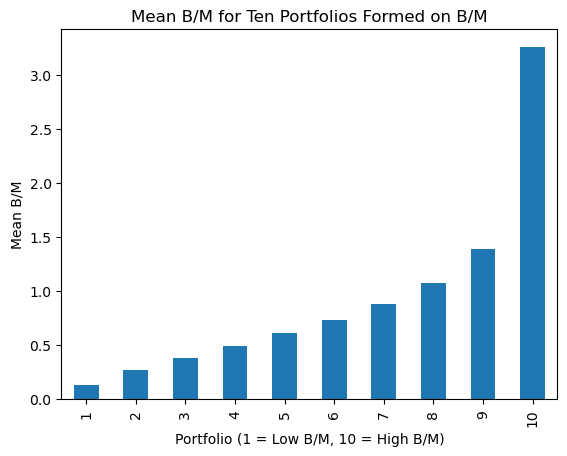

In [28]:
(
    portfolios
    .groupby(by=['Portfolio', 'Date'])
    ['BM']
    .mean()
    .groupby(by=['Portfolio'])
    .mean()
    .plot(kind='bar')
)
plt.ylabel('Mean B/M')
plt.xlabel('Portfolio (1 = Low B/M, 10 = High B/M)')
plt.title('Mean B/M for Ten Portfolios Formed on B/M')
plt.show()

### Returns from July of year $t$ to June of year $t+1$

Now we assign returns to each of these ten portfolios.

In [29]:
returns = (
    pd.merge_asof(
        left=crsp.sort_values(by=['date', 'PERMNO']),
        right=portfolios.sort_values(by=['Date', 'PERMNO']),
        left_on='date',
        right_on='Date',
        by='PERMNO',
        tolerance=pd.Timedelta('366 days')
    )
    [['PERMNO', 'date', 'RET', 'Portfolio']]
    .dropna()
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int))
    .rename(columns={'date': 'Date'})
)

In [30]:
returns

,PERMNO,Date,RET,Portfolio
37636,10006,1966-07-31,-0.0149,6
37640,10102,1966-07-31,-0.0545,6
37641,10137,1966-07-31,0.0105,4
37642,10145,1966-07-31,-0.0129,6
37643,10153,1966-07-31,-0.0788,9
...,...,...,...,...
3457680,93397,2024-12-31,-0.1174,5
3457681,93426,2024-12-31,0.0218,7
3457682,93429,2024-12-31,-0.0947,3
3457683,93434,2024-12-31,0.1333,10


## Performance of Portfolios Formed on B/M

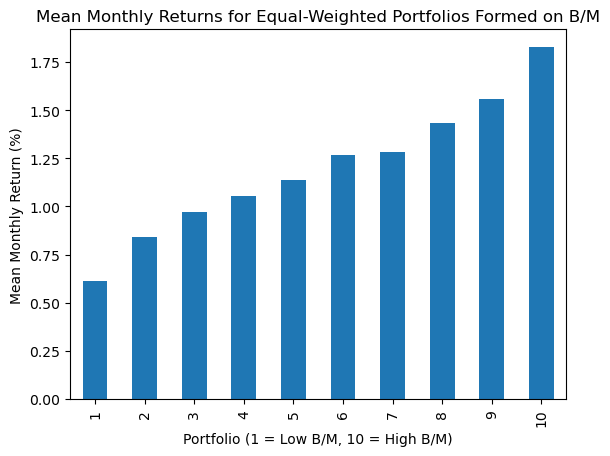

In [31]:
(
    returns
    .groupby(['Portfolio', 'Date'])
    ['RET']
    .mean()
    .groupby(['Portfolio'])
    .mean()
    .mul(100)
    .plot(kind='bar')
)
plt.ylabel('Mean Monthly Return (%)')
plt.xlabel('Portfolio (1 = Low B/M, 10 = High B/M)')
plt.title('Mean Monthly Returns for Equal-Weighted Portfolios Formed on B/M')
plt.show()

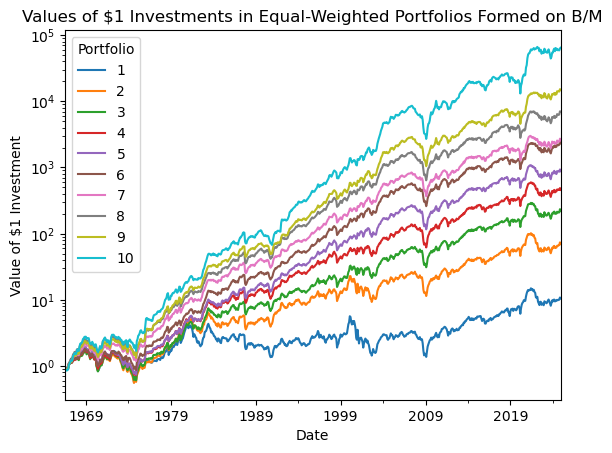

In [33]:
(
    returns
    .groupby(['Portfolio', 'Date'])
    ['RET']
    .mean()
    .unstack('Portfolio')
    .add(1)
    .cumprod()
    .plot()
)
plt.semilogy()
plt.ylabel('Value of $1 Investment')
plt.title('Values of $1 Investments in Equal-Weighted Portfolios Formed on B/M')
plt.show()

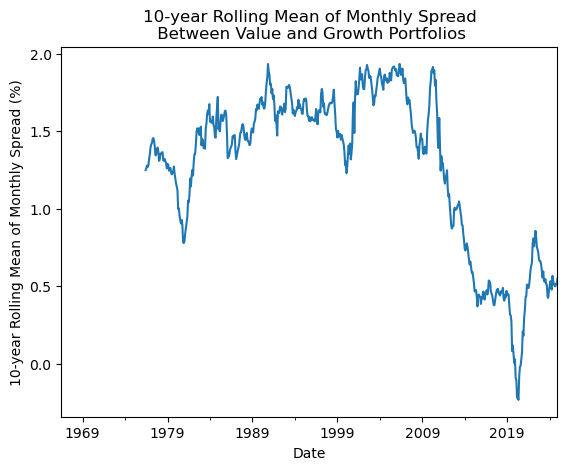

In [36]:
(
    returns
    .groupby(['Portfolio', 'Date'])
    ['RET']
    .mean()
    .unstack('Portfolio')
    .assign(Diff=lambda x: x[10] - x[1])
    ['Diff']
    .rolling(12*10)
    .mean()
    .mul(100)
    .plot()
)
plt.ylabel('10-year Rolling Mean of Monthly Spread (%)')
plt.title('10-year Rolling Mean of Monthly Spread\n Between Value and Growth Portfolios')
plt.show()